In [60]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import holoviews as hv


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, Permute, Multiply, Reshape

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor


from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
survey_2010 = pd.read_csv('Resources/cut_surveys/2010_cut.csv')
survey_2011 = pd.read_csv('Resources/cut_surveys/2011_cut.csv')
survey_2012_0 = pd.read_csv('Resources/cut_surveys/2012_cut_0.csv')
survey_2012_1 = pd.read_csv('Resources/cut_surveys/2012_cut_1.csv')
survey_2012_2 = pd.read_csv('Resources/cut_surveys/2012_cut_2.csv')
survey_2012_3 = pd.read_csv('Resources/cut_surveys/2012_cut_3.csv')
survey_2013 = pd.read_csv('Resources/cut_surveys/2013_cut.csv')
survey_2014 = pd.read_csv('Resources/cut_surveys/2014_cut.csv')
survey_2015 = pd.read_csv('Resources/cut_surveys/2015_cut.csv')
survey_2016 = pd.read_csv('Resources/cut_surveys/2016_cut.csv')
survey_2017 = pd.read_csv('Resources/cut_surveys/2017_cut.csv')
survey_2018_0 = pd.read_csv('Resources/cut_surveys/2018_cut_0.csv')
survey_2018_1 = pd.read_csv('Resources/cut_surveys/2018_cut_1.csv')
survey_2018_2 = pd.read_csv('Resources/cut_surveys/2018_cut_2.csv')
survey_2019_0 = pd.read_csv('Resources/cut_surveys/2019_cut_0.csv')
survey_2019_1 = pd.read_csv('Resources/cut_surveys/2019_cut_1.csv')
survey_2019_2 = pd.read_csv('Resources/cut_surveys/2019_cut_2.csv')
survey_2020_0 = pd.read_csv('Resources/cut_surveys/2020_cut_0.csv')
survey_2020_1 = pd.read_csv('Resources/cut_surveys/2020_cut_1.csv')
survey_2020_2 = pd.read_csv('Resources/cut_surveys/2020_cut_2.csv')
survey_2020_3 = pd.read_csv('Resources/cut_surveys/2020_cut_3.csv')
survey_2020_4 = pd.read_csv('Resources/cut_surveys/2020_cut_4.csv')
survey_2021 = pd.read_csv('Resources/cut_surveys/2021_cut.csv')
survey_2022_0 = pd.read_csv('Resources/cut_surveys/2022_cut_0.csv')
survey_2022_1 = pd.read_csv('Resources/cut_surveys/2022_cut_1.csv')
survey_2022_2 = pd.read_csv('Resources/cut_surveys/2022_cut_2.csv')

survey_2012 = pd.concat([survey_2012_0, survey_2012_1, survey_2012_2, survey_2012_3], ignore_index=True)
survey_2018 = pd.concat([survey_2018_0, survey_2018_1, survey_2018_2], ignore_index=True)
survey_2019 = pd.concat([survey_2019_0, survey_2019_1, survey_2019_2], ignore_index=True)
survey_2020 = pd.concat([survey_2020_0, survey_2020_1, survey_2020_2, survey_2020_3, survey_2020_4], ignore_index=True)
survey_2022 = pd.concat([survey_2022_0, survey_2022_1, survey_2022_2], ignore_index=True)

In [ ]:
def scale_to_1_to_5(column_values):
    """
    Scale a list of values to a range of 1 to 5, handling 0 and NaN values.

    Args:
    column_values (list): A list of numerical values to be scaled.

    Returns:
    list: A new list with scaled values in the range of 1 to 5.
    """
    scaled_values = []  # Create an empty list to store scaled values
    min_value = np.nanmin(column_values)  # Find the minimum value in the input column, ignoring NaN
    max_value = np.nanmax(column_values)  # Find the maximum value in the input column, ignoring NaN

    # Check if all values are NaN, in which case return a list of NaN
    if np.isnan(min_value) and np.isnan(max_value):
        return [np.nan] * len(column_values)

    # Iterate through each value in the input column
    for value in column_values:
        # Check if the value is NaN, and if so, append NaN to the result list
        if np.isnan(value):
            scaled_values.append(np.nan)
        else:
            # Scale the non-NaN value to the range of 1 to 5 using a linear transformation
            scaled_value = 1 + ((value - min_value) / (max_value - min_value)) * 4
            scaled_values.append(scaled_value)  # Append the scaled value to the result list

    return scaled_values

In [ ]:
print(survey_2010.shape)
print(survey_2010.columns.unique())
for col in survey_2010.columns:
    print(col, survey_2010[col].unique())


# Questions 1 - 19 are my_work_experience questions
my_work_experience_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8',
                                'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15',
                                'Q16', 'Q17', 'Q18', 'Q19']


# Questions 20 - 28 are my_work_unit questions
my_work_unit_columns = ['Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27',
                        'Q28']

# Questions 29 - 41 are my_agency questions --> (My Organization)
my_organization_columns = ['Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36',
                            'Q37', 'Q38', 'Q39', 'Q40', 'Q41']

# Questions 42 - 62 are my_work_experience questions
    #Questions 42-52 are My Supervisor
my_supervisor_columns = ['Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49',
                        'Q50', 'Q51', 'Q52']
    #Questions 53-62 are Leadership
leadership_columns = ['Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60',
                        'Q61', 'Q62']

# Questions 63 - 71 are my_satisfaction questions
my_satisfaction_columns = ['Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70',
                            'Q71']

# Questions 72 - 78 are work_life questions / or special --> (Employee Experience)
employee_experience_columns = ['Q72', 'Q73', 'Q74', 'Q75', 'Q76', 'Q77', 'Q78']


#Add Diversity, Equity, Inclusion, and Accessibility with sets of zero
survey_2010['DEIA'] = 0

#Add Circumstantial with sets of zero
survey_2010['circumstantial'] = 0

#Add DLEAVING/DRETIRE and drop all other demographics
survey_2010['DLEAVING'].replace('A', 5, inplace=True)
survey_2010['DLEAVING'].replace('B', 4, inplace=True)
survey_2010['DLEAVING'].replace('C', 3, inplace=True)
survey_2010['DLEAVING'].replace('D', 2, inplace=True)
survey_2010['DLEAVING'].replace('E', 1, inplace=True)


survey_2010['DRETIRE'].replace('A', 1, inplace=True)
survey_2010['DRETIRE'].replace('B', 2, inplace=True)
survey_2010['DRETIRE'].replace('C', 3, inplace=True)
survey_2010['DRETIRE'].replace('D', 4, inplace=True)

negativity_index_columns = ['DLEAVING', 'DRETIRE']


survey_2010.replace('X', np.nan, inplace=True)

# convert all values to numeric
survey_2010[my_work_experience_columns] = survey_2010[my_work_experience_columns].apply(pd.to_numeric)
survey_2010[my_work_unit_columns] = survey_2010[my_work_unit_columns].apply(pd.to_numeric)
survey_2010[my_organization_columns] = survey_2010[my_organization_columns].apply(pd.to_numeric)
survey_2010[my_supervisor_columns] = survey_2010[my_supervisor_columns].apply(pd.to_numeric)
survey_2010[leadership_columns] = survey_2010[leadership_columns].apply(pd.to_numeric)
survey_2010[my_satisfaction_columns] = survey_2010[my_satisfaction_columns].apply(pd.to_numeric)
survey_2010[employee_experience_columns] = survey_2010[employee_experience_columns].apply(pd.to_numeric)
survey_2010[negativity_index_columns] = survey_2010[negativity_index_columns].apply(pd.to_numeric)

#scale all columns to 1-5
for col in survey_2010.columns:
    # check if numeric
    if survey_2010[col].dtype == 'int64' or survey_2010[col].dtype == 'float64':
        # scale to 1-5
        survey_2010[col] = scale_to_1_to_5(survey_2010[col])




# Average all of the values in the columns and drop the columns
survey_2010['my_work_experience'] = survey_2010[my_work_experience_columns].mean(axis=1)
survey_2010['my_work_unit'] = survey_2010[my_work_unit_columns].mean(axis=1)
survey_2010['my_organization'] = survey_2010[my_organization_columns].mean(axis=1)
survey_2010['my_supervisor'] = survey_2010[my_supervisor_columns].mean(axis=1)
survey_2010['leadership'] = survey_2010[leadership_columns].mean(axis=1)
survey_2010['my_satisfaction'] = survey_2010[my_satisfaction_columns].mean(axis=1)
survey_2010['employee_experience'] = survey_2010[employee_experience_columns].mean(axis=1)
survey_2010['negativity_index'] = survey_2010[negativity_index_columns].mean(axis=1)

excess_columsn = ['USERID', 'SUBELEM', 'DLOC', 'DSUPER', 'DSEX', 'DMINORITY',
       'DAGEGRP', 'DPAYCAT', 'DFEDTEN', 'DAGYTEN', 'DLEAVING', 'DRETIRE',  'POSTWT']

# Drop all of the columns

survey_2010.drop(columns=my_work_experience_columns + my_work_unit_columns + my_organization_columns
                 +  my_supervisor_columns + leadership_columns + my_satisfaction_columns 
                 + employee_experience_columns + excess_columsn, inplace=True)

# convert AGENCY to agency
survey_2010.rename(columns={'AGENCY': 'agency'}, inplace=True)




In [ ]:
print(survey_2010.shape)
print(survey_2010.columns.unique())
for col in survey_2010.columns:
    print(col, survey_2010[col].unique())

In [ ]:
print(survey_2011.shape)
print(survey_2011.columns.unique())
for col in survey_2011.columns:
    print(col, survey_2011[col].unique())


# Questions 1 - 19 are my_work_experience questions
my_work_experience_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8',
                                'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15',
                                'Q16', 'Q17', 'Q18', 'Q19']

# Questions 20 - 28 are my_work_unit questions
my_work_unit_columns = ['Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27',
                        'Q28']

# Questions 29 - 41 are my_agency questions --> (My Organization)
my_organization_columns = ['Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36',
                            'Q37', 'Q38', 'Q39', 'Q40', 'Q41']

# Questions 42 - 62 are my_work_experience questions
    #Questions 42-52 are My Supervisor
my_supervisor_columns = ['Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49',
                        'Q50', 'Q51', 'Q52']
    #Questions 53-62 are Leadership
leadership_columns = ['Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60',
                        'Q61', 'Q62']

# Questions 63 - 71 are my_satisfaction questions
my_satisfaction_columns = ['Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70',
                            'Q71']

# Questions 72 - 84 are work_life questions / or special --> (Employee Experience)
employee_experience_columns = ['Q72', 'Q73', 'Q74', 'Q75', 'Q76', 'Q77', 'Q78', 'Q79',
                                'Q80', 'Q81', 'Q82', 'Q83', 'Q84']


#Add Diversity, Equity, Inclusion, and Accessibility with sets of zero
survey_2011['DEIA'] = 0
#Add Circumstantial with sets of zero
survey_2011['circumstantial'] = 0
#Add DLEAVING/DRETIRE and drop all other demographics
survey_2011['DLEAVING'].replace('A', 5, inplace=True)
survey_2011['DLEAVING'].replace('B', 4, inplace=True)
survey_2011['DLEAVING'].replace('C', 3, inplace=True)
survey_2011['DLEAVING'].replace('D', 2, inplace=True)
survey_2011['DLEAVING'].replace('E', 1, inplace=True)

survey_2011['DRETIRE'].replace('A', 1, inplace=True)
survey_2011['DRETIRE'].replace('B', 2, inplace=True)
survey_2011['DRETIRE'].replace('C', 3, inplace=True)
survey_2011['DRETIRE'].replace('D', 4, inplace=True)

negativity_index_columns = ['DLEAVING', 'DRETIRE']


survey_2011.replace('X', np.nan, inplace=True)

# convert all values to numeric
survey_2011[my_work_experience_columns] = survey_2011[my_work_experience_columns].apply(pd.to_numeric)
survey_2011[my_work_unit_columns] = survey_2011[my_work_unit_columns].apply(pd.to_numeric)
survey_2011[my_organization_columns] = survey_2011[my_organization_columns].apply(pd.to_numeric)
survey_2011[my_supervisor_columns] = survey_2011[my_supervisor_columns].apply(pd.to_numeric)
survey_2011[leadership_columns] = survey_2011[leadership_columns].apply(pd.to_numeric)
survey_2011[my_satisfaction_columns] = survey_2011[my_satisfaction_columns].apply(pd.to_numeric)
survey_2011[employee_experience_columns] = survey_2011[employee_experience_columns].apply(pd.to_numeric)
survey_2011[negativity_index_columns] = survey_2011[negativity_index_columns].apply(pd.to_numeric)

#scale all columns to 1-5
for col in survey_2011.columns:
    # check if numeric
    if survey_2011[col].dtype == 'int64' or survey_2011[col].dtype == 'float64':
        # scale to 1-5
        survey_2011[col] = scale_to_1_to_5(survey_2011[col])

# Average all of the values in the columns and drop the columns
survey_2011['my_work_experience'] = survey_2011[my_work_experience_columns].mean(axis=1)
survey_2011['my_work_unit'] = survey_2011[my_work_unit_columns].mean(axis=1)
survey_2011['my_organization'] = survey_2011[my_organization_columns].mean(axis=1)
survey_2011['my_supervisor'] = survey_2011[my_supervisor_columns].mean(axis=1)
survey_2011['leadership'] = survey_2011[leadership_columns].mean(axis=1)
survey_2011['my_satisfaction'] = survey_2011[my_satisfaction_columns].mean(axis=1)
survey_2011['employee_experience'] = survey_2011[employee_experience_columns].mean(axis=1)
survey_2011['negativity_index'] = survey_2011[negativity_index_columns].mean(axis=1)

excess_columsn = ['USERID', 'SUBELEM', 'DLOC', 'DSUPER', 'DSEX', 'DMINORITY',
       'DAGEGRP', 'DPAYCAT', 'DFEDTEN', 'DAGYTEN', 'DLEAVING', 'DRETIRE',  'POSTWT']

# Drop all of the columns
survey_2011.drop(columns=my_work_experience_columns + my_work_unit_columns + my_organization_columns
                 +  my_supervisor_columns + leadership_columns + my_satisfaction_columns 
                 + employee_experience_columns + excess_columsn, inplace=True)

# convert AGENCY to agency
survey_2011.rename(columns={'AGENCY': 'agency'}, inplace=True)

In [ ]:
print(survey_2011.shape)
print(survey_2011.columns.unique())

In [ ]:
print(survey_2012.shape)
print(survey_2012.columns.unique())
for col in survey_2012.columns:
    print(col, survey_2012[col].unique())


# Questions 1 - 19 are my_work_experience questions
my_work_experience_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8',
                                'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15',
                                'Q16', 'Q17', 'Q18', 'Q19']


# Questions 20 - 28 are my_work_unit questions
my_work_unit_columns = ['Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27',
                        'Q28']

# Questions 29 - 41 are my_agency questions --> (My Organization)
my_organization_columns = ['Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36',
                            'Q37', 'Q38', 'Q39', 'Q40', 'Q41']

# Questions 42 - 62 are my_work_experience questions
    #Questions 42-52 are My Supervisor
my_supervisor_columns = ['Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49',
                        'Q50', 'Q51', 'Q52']
    #Questions 53-62 are Leadership
leadership_columns = ['Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60',
                        'Q61', 'Q62']

# Questions 63 - 71 are my_satisfaction questions
my_satisfaction_columns = ['Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70',
                            'Q71']

# Questions 72 - 84 are work_life questions / or special --> (Employee Experience)
employee_experience_columns = ['Q72', 'Q73', 'Q74', 'Q75', 'Q76', 'Q77', 'Q78', 'Q79',
                                'Q80', 'Q81', 'Q82', 'Q83', 'Q84']


#Add Diversity, Equity, Inclusion, and Accessibility with sets of zero
survey_2012['DEIA'] = 0
#Add Circumstantial with sets of zero
survey_2012['circumstantial'] = 0
#Add DLEAVING/DRETIRE and drop all other demographics
survey_2012['DLEAVING'].replace('A', 5, inplace=True)
survey_2012['DLEAVING'].replace('B', 4, inplace=True)
survey_2012['DLEAVING'].replace('C', 3, inplace=True)
survey_2012['DLEAVING'].replace('D', 2, inplace=True)

survey_2012['DRETIRE'].replace('A', 1, inplace=True)
survey_2012['DRETIRE'].replace('B', 5, inplace=True)

negativity_index_columns = ['DLEAVING', 'DRETIRE']


survey_2012.replace('X', np.nan, inplace=True)

# convert all values to numeric
survey_2012[my_work_experience_columns] = survey_2012[my_work_experience_columns].apply(pd.to_numeric)
survey_2012[my_work_unit_columns] = survey_2012[my_work_unit_columns].apply(pd.to_numeric)
survey_2012[my_organization_columns] = survey_2012[my_organization_columns].apply(pd.to_numeric)
survey_2012[my_supervisor_columns] = survey_2012[my_supervisor_columns].apply(pd.to_numeric)
survey_2012[leadership_columns] = survey_2012[leadership_columns].apply(pd.to_numeric)
survey_2012[my_satisfaction_columns] = survey_2012[my_satisfaction_columns].apply(pd.to_numeric)
survey_2012[employee_experience_columns] = survey_2012[employee_experience_columns].apply(pd.to_numeric)
survey_2012[negativity_index_columns] = survey_2012[negativity_index_columns].apply(pd.to_numeric)

#scale all columns to 1-5
for col in survey_2012.columns:
    # check if numeric
    if survey_2012[col].dtype == 'int64' or survey_2012[col].dtype == 'float64':
        # scale to 1-5
        survey_2012[col] = scale_to_1_to_5(survey_2012[col])

# Average all of the values in the columns and drop the columns
survey_2012['my_work_experience'] = survey_2012[my_work_experience_columns].mean(axis=1)
survey_2012['my_work_unit'] = survey_2012[my_work_unit_columns].mean(axis=1)
survey_2012['my_organization'] = survey_2012[my_organization_columns].mean(axis=1)
survey_2012['my_supervisor'] = survey_2012[my_supervisor_columns].mean(axis=1)
survey_2012['leadership'] = survey_2012[leadership_columns].mean(axis=1)
survey_2012['my_satisfaction'] = survey_2012[my_satisfaction_columns].mean(axis=1)
survey_2012['employee_experience'] = survey_2012[employee_experience_columns].mean(axis=1)
survey_2012['negativity_index'] = survey_2012[negativity_index_columns].mean(axis=1)

excess_columsn = ['UserID', 'SUBELEM', 'DSUPER', 'DSEX', 'DMINORITY',
       'DAGEGRP', 'DFEDTEN', 'DLEAVING', 'DRETIRE', 'DMIL', 'DDIS','POSTWT']

# Drop all of the columns
survey_2012.drop(columns=my_work_experience_columns + my_work_unit_columns + my_organization_columns
                 +  my_supervisor_columns + leadership_columns + my_satisfaction_columns 
                 + employee_experience_columns + excess_columsn, inplace=True)

print(survey_2012.shape)
print(survey_2012.columns.unique())

#convert AGENCY to agency
survey_2012.rename(columns={'AGENCY': 'agency'}, inplace=True)

In [ ]:
print(survey_2013.shape)
print(survey_2013.columns.unique())
for col in survey_2013.columns:
    print(col, survey_2013[col].unique())


# Questions 1 - 19 are my_work_experience questions
my_work_experience_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8',
                                'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15',
                                'Q16', 'Q17', 'Q18', 'Q19']


# Questions 20 - 28 are my_work_unit questions
my_work_unit_columns = ['Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27',
                        'Q28']

# Questions 29 - 41 are my_agency questions --> (My Organization)
my_organization_columns = ['Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36',
                            'Q37', 'Q38', 'Q39', 'Q40', 'Q41']

# Questions 42 - 62 are my_work_experience questions
    #Questions 42-52 are My Supervisor
my_supervisor_columns = ['Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49',
                        'Q50', 'Q51', 'Q52']
    #Questions 53-62 are Leadership
leadership_columns = ['Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60',
                        'Q61', 'Q62']

# Questions 63 - 71 are my_satisfaction questions
my_satisfaction_columns = ['Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70',
                            'Q71']

# Questions 72 - 84 are work_life questions / or special --> (Employee Experience)
employee_experience_columns = ['Q72', 'Q73', 'Q74', 'Q75', 'Q76', 'Q77', 'Q78', 'Q79',
                                'Q80', 'Q81', 'Q82', 'Q83', 'Q84']


#Add Diversity, Equity, Inclusion, and Accessibility with sets of zero
survey_2013['DEIA'] = 0
#Add Circumstantial with sets of zero
survey_2013['circumstantial'] = 0
#Add DLEAVING/DRETIRE and drop all other demographics
survey_2013['DLEAVING'].replace('A', 5, inplace=True)
survey_2013['DLEAVING'].replace('B', 4, inplace=True)
survey_2013['DLEAVING'].replace('C', 3, inplace=True)
survey_2013['DLEAVING'].replace('D', 2, inplace=True)

survey_2013['DRETIRE'].replace('A', 1, inplace=True)
survey_2013['DRETIRE'].replace('B', 5, inplace=True)

negativity_index_columns = ['DLEAVING', 'DRETIRE']


survey_2013.replace('X', np.nan, inplace=True)

# convert all values to numeric
survey_2013[my_work_experience_columns] = survey_2013[my_work_experience_columns].apply(pd.to_numeric)
survey_2013[my_work_unit_columns] = survey_2013[my_work_unit_columns].apply(pd.to_numeric)
survey_2013[my_organization_columns] = survey_2013[my_organization_columns].apply(pd.to_numeric)
survey_2013[my_supervisor_columns] = survey_2013[my_supervisor_columns].apply(pd.to_numeric)
survey_2013[leadership_columns] = survey_2013[leadership_columns].apply(pd.to_numeric)
survey_2013[my_satisfaction_columns] = survey_2013[my_satisfaction_columns].apply(pd.to_numeric)
survey_2013[employee_experience_columns] = survey_2013[employee_experience_columns].apply(pd.to_numeric)
survey_2013[negativity_index_columns] = survey_2013[negativity_index_columns].apply(pd.to_numeric)

#scale all columns to 1-5
for col in survey_2013.columns:
    # check if numeric
    if survey_2013[col].dtype == 'int64' or survey_2013[col].dtype == 'float64':
        # scale to 1-5
        survey_2013[col] = scale_to_1_to_5(survey_2013[col])

# Average all of the values in the columns and drop the columns
survey_2013['my_work_experience'] = survey_2013[my_work_experience_columns].mean(axis=1)
survey_2013['my_work_unit'] = survey_2013[my_work_unit_columns].mean(axis=1)
survey_2013['my_organization'] = survey_2013[my_organization_columns].mean(axis=1)
survey_2013['my_supervisor'] = survey_2013[my_supervisor_columns].mean(axis=1)
survey_2013['leadership'] = survey_2013[leadership_columns].mean(axis=1)
survey_2013['my_satisfaction'] = survey_2013[my_satisfaction_columns].mean(axis=1)
survey_2013['employee_experience'] = survey_2013[employee_experience_columns].mean(axis=1)
survey_2013['negativity_index'] = survey_2013[negativity_index_columns].mean(axis=1)

excess_columsn = ['USERID', 'PLEVEL1', 'PLEVEL2', 'DSUPER', 'DSEX', 'DMINORITY',
       'DAGEGRP', 'DPAYCAT', 'DFEDTEN', 'DLEAVING', 'DRETIRE', 'DMIL', 'DDIS','POSTWT']

# Drop all of the columns
survey_2013.drop(columns=my_work_experience_columns + my_work_unit_columns + my_organization_columns
                 +  my_supervisor_columns + leadership_columns + my_satisfaction_columns 
                 + employee_experience_columns + excess_columsn, inplace=True)

print(survey_2013.shape)
print(survey_2013.columns.unique())

In [ ]:
print(survey_2014.shape)
print(survey_2014.columns.unique())
for col in survey_2014.columns:
    print(col, survey_2014[col].unique())


# Questions 1 - 19 are my_work_experience questions
my_work_experience_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8',
                                'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15',
                                'Q16', 'Q17', 'Q18', 'Q19']


# Questions 20 - 28 are my_work_unit questions
my_work_unit_columns = ['Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27',
                        'Q28']

# Questions 29 - 41 are my_agency questions --> (My Organization)
my_organization_columns = ['Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36',
                            'Q37', 'Q38', 'Q39', 'Q40', 'Q41']

# Questions 42 - 62 are my_work_experience questions
    #Questions 42-52 are My Supervisor
my_supervisor_columns = ['Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49',
                        'Q50', 'Q51', 'Q52']
    #Questions 53-62 are Leadership
leadership_columns = ['Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60',
                        'Q61', 'Q62']

# Questions 63 - 71 are my_satisfaction questions
my_satisfaction_columns = ['Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70',
                            'Q71']

# Questions 72 - 84 are work_life questions / or special --> (Employee Experience)
employee_experience_columns = ['Q72', 'Q73', 'Q74', 'Q75', 'Q76', 'Q77', 'Q78', 'Q79',
                                'Q80', 'Q81', 'Q82', 'Q83', 'Q84']


#Add Diversity, Equity, Inclusion, and Accessibility with sets of zero
survey_2014['DEIA'] = 0
#Add Circumstantial with sets of zero
survey_2014['circumstantial'] = 0
#Add DLEAVING/DRETIRE and drop all other demographics
survey_2014['DLEAVING'].replace('A', 5, inplace=True)
survey_2014['DLEAVING'].replace('B', 4, inplace=True)
survey_2014['DLEAVING'].replace('C', 3, inplace=True)
survey_2014['DLEAVING'].replace('D', 2, inplace=True)

survey_2014['DRETIRE'].replace('A', 1, inplace=True)
survey_2014['DRETIRE'].replace('B', 5, inplace=True)

negativity_index_columns = ['DLEAVING', 'DRETIRE']

survey_2014.replace('X', np.nan, inplace=True)

# convert all values to numeric
survey_2014[my_work_experience_columns] = survey_2014[my_work_experience_columns].apply(pd.to_numeric)
survey_2014[my_work_unit_columns] = survey_2014[my_work_unit_columns].apply(pd.to_numeric)
survey_2014[my_organization_columns] = survey_2014[my_organization_columns].apply(pd.to_numeric)
survey_2014[my_supervisor_columns] = survey_2014[my_supervisor_columns].apply(pd.to_numeric)
survey_2014[leadership_columns] = survey_2014[leadership_columns].apply(pd.to_numeric)
survey_2014[my_satisfaction_columns] = survey_2014[my_satisfaction_columns].apply(pd.to_numeric)
survey_2014[employee_experience_columns] = survey_2014[employee_experience_columns].apply(pd.to_numeric)
survey_2014[negativity_index_columns] = survey_2014[negativity_index_columns].apply(pd.to_numeric)

#scale all columns to 1-5
for col in survey_2014.columns:
    # check if numeric
    if survey_2014[col].dtype == 'int64' or survey_2014[col].dtype == 'float64':
        # scale to 1-5
        survey_2014[col] = scale_to_1_to_5(survey_2014[col])

# Average all of the values in the columns and drop the columns
survey_2014['my_work_experience'] = survey_2014[my_work_experience_columns].mean(axis=1)
survey_2014['my_work_unit'] = survey_2014[my_work_unit_columns].mean(axis=1)
survey_2014['my_organization'] = survey_2014[my_organization_columns].mean(axis=1)
survey_2014['my_supervisor'] = survey_2014[my_supervisor_columns].mean(axis=1)
survey_2014['leadership'] = survey_2014[leadership_columns].mean(axis=1)
survey_2014['my_satisfaction'] = survey_2014[my_satisfaction_columns].mean(axis=1)
survey_2014['employee_experience'] = survey_2014[employee_experience_columns].mean(axis=1)

survey_2014['negativity_index'] = survey_2014[negativity_index_columns].mean(axis=1)

excess_columsn = ['USERID', 'PLEVEL1', 'PLEVEL2', 'DSUPER', 'DSEX', 'DMINORITY', 'DEDUC',
       'DAGEGRP', 'DPAYCAT', 'DFEDTEN', 'DLEAVING', 'DRETIRE', 'DMIL', 'DDIS','POSTWT']

# Drop all of the columns
survey_2014.drop(columns=my_work_experience_columns + my_work_unit_columns + my_organization_columns
                 +  my_supervisor_columns + leadership_columns + my_satisfaction_columns 
                 + employee_experience_columns + excess_columsn, inplace=True)

print(survey_2014.shape)
print(survey_2014.columns.unique())

In [ ]:
print(survey_2015.shape)
print(survey_2015.columns.unique())
for col in survey_2015.columns:
    print(col, survey_2015[col].unique())


# Questions 1 - 19 are my_work_experience questions
my_work_experience_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8',
                                'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15',
                                'Q16', 'Q17', 'Q18', 'Q19']


# Questions 20 - 28 are my_work_unit questions
my_work_unit_columns = ['Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27',
                        'Q28']

# Questions 29 - 41 are my_agency questions --> (My Organization)
my_organization_columns = ['Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36',
                            'Q37', 'Q38', 'Q39', 'Q40', 'Q41']

# Questions 42 - 62 are my_work_experience questions
    #Questions 42-52 are My Supervisor
my_supervisor_columns = ['Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49',
                        'Q50', 'Q51', 'Q52']
    #Questions 53-62 are Leadership
leadership_columns = ['Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60',
                        'Q61', 'Q62']

# Questions 63 - 71 are my_satisfaction questions
my_satisfaction_columns = ['Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70',
                            'Q71']

# Questions 72 - 84 are work_life questions / or special --> (Employee Experience)
employee_experience_columns = ['Q72', 'Q73', 'Q74', 'Q75', 'Q76', 'Q77', 'Q78', 'Q79',
                                'Q80', 'Q81', 'Q82', 'Q83', 'Q84']


#Add Diversity, Equity, Inclusion, and Accessibility with sets of zero
survey_2015['DEIA'] = 0
#Add Circumstantial with sets of zero
survey_2015['circumstantial'] = 0
#Add DLEAVING/DRETIRE and drop all other demographics
survey_2015['DLEAVING'].replace('A', 5, inplace=True)
survey_2015['DLEAVING'].replace('B', 4, inplace=True)
survey_2015['DLEAVING'].replace('C', 3, inplace=True)
survey_2015['DLEAVING'].replace('D', 2, inplace=True)

survey_2015['DRETIRE'].replace('A', 1, inplace=True)
survey_2015['DRETIRE'].replace('B', 5, inplace=True)

negativity_index_columns = ['DLEAVING', 'DRETIRE']

survey_2015.replace('X', np.nan, inplace=True)

# convert all values to numeric
survey_2015[my_work_experience_columns] = survey_2015[my_work_experience_columns].apply(pd.to_numeric)
survey_2015[my_work_unit_columns] = survey_2015[my_work_unit_columns].apply(pd.to_numeric)
survey_2015[my_organization_columns] = survey_2015[my_organization_columns].apply(pd.to_numeric)
survey_2015[my_supervisor_columns] = survey_2015[my_supervisor_columns].apply(pd.to_numeric)
survey_2015[leadership_columns] = survey_2015[leadership_columns].apply(pd.to_numeric)
survey_2015[my_satisfaction_columns] = survey_2015[my_satisfaction_columns].apply(pd.to_numeric)
survey_2015[employee_experience_columns] = survey_2015[employee_experience_columns].apply(pd.to_numeric)
survey_2015[negativity_index_columns] = survey_2015[negativity_index_columns].apply(pd.to_numeric)

#scale all columns to 1-5
for col in survey_2015.columns:
    # check if numeric
    if survey_2015[col].dtype == 'int64' or survey_2015[col].dtype == 'float64':
        # scale to 1-5
        survey_2015[col] = scale_to_1_to_5(survey_2015[col])

# Average all of the values in the columns and drop the columns
survey_2015['my_work_experience'] = survey_2015[my_work_experience_columns].mean(axis=1)
survey_2015['my_work_unit'] = survey_2015[my_work_unit_columns].mean(axis=1)
survey_2015['my_organization'] = survey_2015[my_organization_columns].mean(axis=1)
survey_2015['my_supervisor'] = survey_2015[my_supervisor_columns].mean(axis=1)
survey_2015['leadership'] = survey_2015[leadership_columns].mean(axis=1)
survey_2015['my_satisfaction'] = survey_2015[my_satisfaction_columns].mean(axis=1)
survey_2015['employee_experience'] = survey_2015[employee_experience_columns].mean(axis=1)
survey_2015['negativity_index'] = survey_2015[negativity_index_columns].mean(axis=1)

excess_columsn = ['RANDOM', 'PLEVEL1', 'PLEVEL2', 'DSUPER', 'DSEX', 'DMINORITY', 'DEDUC',
       'DAGEGRP', 'DFEDTEN', 'DLEAVING', 'DRETIRE', 'DMIL', 'DDIS','POSTWT']

# Drop all of the columns
survey_2015.drop(columns=my_work_experience_columns + my_work_unit_columns + my_organization_columns
                 +  my_supervisor_columns + leadership_columns + my_satisfaction_columns 
                 + employee_experience_columns + excess_columsn, inplace=True)

print(survey_2015.shape)
print(survey_2015.columns.unique())

In [ ]:
print(survey_2016.shape)
print(survey_2016.columns.unique())
for col in survey_2016.columns:
    print(col, survey_2016[col].unique())


# Questions 1 - 19 are my_work_experience questions
my_work_experience_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8',
                                'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15',
                                'Q16', 'Q17', 'Q18', 'Q19']


# Questions 20 - 28 are my_work_unit questions
my_work_unit_columns = ['Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27',
                        'Q28']

# Questions 29 - 41 are my_agency questions --> (My Organization)
my_organization_columns = ['Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36',
                            'Q37', 'Q38', 'Q39', 'Q40', 'Q41']

# Questions 42 - 62 are my_work_experience questions
    #Questions 42-52 are My Supervisor
my_supervisor_columns = ['Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49',
                        'Q50', 'Q51', 'Q52']
    #Questions 53-62 are Leadership
leadership_columns = ['Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60',
                        'Q61', 'Q62']

# Questions 63 - 71 are my_satisfaction questions
my_satisfaction_columns = ['Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70',
                            'Q71']




#Add Diversity, Equity, Inclusion, and Accessibility with sets of zero
survey_2016['DEIA'] = 0
#Add Circumstantial with sets of zero
survey_2016['circumstantial'] = 0

# Add employee experience with sets of zero
survey_2016['employee_experience'] = 0

#Add DLEAVING/DRETIRE and drop all other demographics
survey_2016['DLEAVING'].replace('A', 5, inplace=True)
survey_2016['DLEAVING'].replace('B', 4, inplace=True)
survey_2016['DLEAVING'].replace('C', 3, inplace=True)
survey_2016['DLEAVING'].replace('D', 2, inplace=True)


negativity_index_columns = ['DLEAVING']


survey_2016.replace('X', np.nan, inplace=True)

# convert all values to numeric
survey_2016[my_work_experience_columns] = survey_2016[my_work_experience_columns].apply(pd.to_numeric)
survey_2016[my_work_unit_columns] = survey_2016[my_work_unit_columns].apply(pd.to_numeric)
survey_2016[my_organization_columns] = survey_2016[my_organization_columns].apply(pd.to_numeric)
survey_2016[my_supervisor_columns] = survey_2016[my_supervisor_columns].apply(pd.to_numeric)
survey_2016[leadership_columns] = survey_2016[leadership_columns].apply(pd.to_numeric)
survey_2016[my_satisfaction_columns] = survey_2016[my_satisfaction_columns].apply(pd.to_numeric)
survey_2016[negativity_index_columns] = survey_2016[negativity_index_columns].apply(pd.to_numeric)

#scale all columns to 1-5
for col in survey_2016.columns:
    # check if numeric
    if survey_2016[col].dtype == 'int64' or survey_2016[col].dtype == 'float64':
        # scale to 1-5
        survey_2016[col] = scale_to_1_to_5(survey_2016[col])

# Average all of the values in the columns and drop the columns
survey_2016['my_work_experience'] = survey_2016[my_work_experience_columns].mean(axis=1)
survey_2016['my_work_unit'] = survey_2016[my_work_unit_columns].mean(axis=1)
survey_2016['my_organization'] = survey_2016[my_organization_columns].mean(axis=1)
survey_2016['my_supervisor'] = survey_2016[my_supervisor_columns].mean(axis=1)
survey_2016['leadership'] = survey_2016[leadership_columns].mean(axis=1)
survey_2016['my_satisfaction'] = survey_2016[my_satisfaction_columns].mean(axis=1)
survey_2016['negativity_index'] = survey_2016[negativity_index_columns].mean(axis=1)

excess_columsn = ['RANDOM', 'plevel1', 'DSUPER', 'DSEX', 'DMINORITY', 
       'DAGEGRP', 'DLEAVING','POSTWT']

# Drop all of the columns
survey_2016.drop(columns=my_work_experience_columns + my_work_unit_columns + my_organization_columns
                 +  my_supervisor_columns + leadership_columns + my_satisfaction_columns 
                 + excess_columsn, inplace=True)

#convert AGENCY to agency
survey_2016.rename(columns={'AGENCY': 'agency'}, inplace=True)

print(survey_2016.shape)
print(survey_2016.columns.unique())

In [ ]:
print(survey_2017.shape)
print(survey_2017.columns.unique())
for col in survey_2017.columns:
    print(col, survey_2017[col].unique())


# Questions 1 - 19 are my_work_experience questions
my_work_experience_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8',
                                'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15',
                                'Q16', 'Q17', 'Q18', 'Q19']


# Questions 20 - 28 are my_work_unit questions
my_work_unit_columns = ['Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27',
                        'Q28']

# Questions 29 - 41 are my_agency questions --> (My Organization)
my_organization_columns = ['Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36',
                            'Q37', 'Q38', 'Q39', 'Q40', 'Q41']

# Questions 42 - 62 are my_work_experience questions
    #Questions 42-52 are My Supervisor
my_supervisor_columns = ['Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49',
                        'Q50', 'Q51', 'Q52']
    #Questions 53-62 are Leadership
leadership_columns = ['Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60',
                        'Q61', 'Q62']

# Questions 63 - 71 are my_satisfaction questions
my_satisfaction_columns = ['Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70',
                            'Q71']




#Add Diversity, Equity, Inclusion, and Accessibility with sets of zero
survey_2017['DEIA'] = 0
#Add Circumstantial with sets of zero
survey_2017['circumstantial'] = 0

# Add employee experience with sets of zero
survey_2017['employee_experience'] = 0

#Add DLEAVING/DRETIRE and drop all other demographics
survey_2017['DLEAVING'].replace('A', 5, inplace=True)
survey_2017['DLEAVING'].replace('B', 4, inplace=True)
survey_2017['DLEAVING'].replace('C', 3, inplace=True)
survey_2017['DLEAVING'].replace('D', 2, inplace=True)


negativity_index_columns = ['DLEAVING']


survey_2017.replace('X', np.nan, inplace=True)

# convert all values to numeric
survey_2017[my_work_experience_columns] = survey_2017[my_work_experience_columns].apply(pd.to_numeric)
survey_2017[my_work_unit_columns] = survey_2017[my_work_unit_columns].apply(pd.to_numeric)
survey_2017[my_organization_columns] = survey_2017[my_organization_columns].apply(pd.to_numeric)
survey_2017[my_supervisor_columns] = survey_2017[my_supervisor_columns].apply(pd.to_numeric)
survey_2017[leadership_columns] = survey_2017[leadership_columns].apply(pd.to_numeric)
survey_2017[my_satisfaction_columns] = survey_2017[my_satisfaction_columns].apply(pd.to_numeric)
survey_2017[negativity_index_columns] = survey_2017[negativity_index_columns].apply(pd.to_numeric)

#scale all columns to 1-5
for col in survey_2017.columns:
    # check if numeric
    if survey_2017[col].dtype == 'int64' or survey_2017[col].dtype == 'float64':
        # scale to 1-5
        survey_2017[col] = scale_to_1_to_5(survey_2017[col])

# Average all of the values in the columns and drop the columns
survey_2017['my_work_experience'] = survey_2017[my_work_experience_columns].mean(axis=1)
survey_2017['my_work_unit'] = survey_2017[my_work_unit_columns].mean(axis=1)
survey_2017['my_organization'] = survey_2017[my_organization_columns].mean(axis=1)
survey_2017['my_supervisor'] = survey_2017[my_supervisor_columns].mean(axis=1)
survey_2017['leadership'] = survey_2017[leadership_columns].mean(axis=1)
survey_2017['my_satisfaction'] = survey_2017[my_satisfaction_columns].mean(axis=1)
survey_2017['negativity_index'] = survey_2017[negativity_index_columns].mean(axis=1)

excess_columns = ['LEVEL1', 'DSUPER','DEDUC','DFEDTEN', 'DSEX', 'DMINORITY', 
       'DLEAVING','POSTWT']

# Drop all of the columns
survey_2017.drop(columns=my_work_experience_columns + my_work_unit_columns + my_organization_columns
                 +  my_supervisor_columns + leadership_columns + my_satisfaction_columns 
                 + excess_columns, inplace=True)

#convert AGENCY to agency
survey_2017.rename(columns={'AGENCY': 'agency'}, inplace=True)

print(survey_2017.shape)
print(survey_2017.columns.unique())

In [ ]:
print(survey_2018.shape)
print(survey_2018.columns.unique())
for col in survey_2018.columns:
    print(col, survey_2018[col].unique())


# Questions 1 - 19 are my_work_experience questions
my_work_experience_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8',
                                'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15',
                                'Q16', 'Q17', 'Q18', 'Q19']


# Questions 20 - 28 are my_work_unit questions
my_work_unit_columns = ['Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27',
                        'Q28']

# Questions 29 - 41 are my_agency questions --> (My Organization)
my_organization_columns = ['Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36',
                            'Q37', 'Q38', 'Q39', 'Q40', 'Q41']

# Questions 42 - 62 are my_work_experience questions
    #Questions 42-52 are My Supervisor
my_supervisor_columns = ['Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49',
                        'Q50', 'Q51', 'Q52']
    #Questions 53-62 are Leadership
leadership_columns = ['Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60',
                        'Q61', 'Q62']

# Questions 63 - 71 are my_satisfaction questions
my_satisfaction_columns = ['Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70',
                            'Q71']




#Add Diversity, Equity, Inclusion, and Accessibility with sets of zero
survey_2018['DEIA'] = 0
#Add Circumstantial with sets of zero
survey_2018['circumstantial'] = 0

# Add employee experience with sets of zero
survey_2018['employee_experience'] = 0

#Add DLEAVING/DRETIRE and drop all other demographics
survey_2018['DLEAVING'].replace('A', 5, inplace=True)
survey_2018['DLEAVING'].replace('B', 4, inplace=True)
survey_2018['DLEAVING'].replace('C', 3, inplace=True)
survey_2018['DLEAVING'].replace('D', 2, inplace=True)


negativity_index_columns = ['DLEAVING']


survey_2018.replace('X', np.nan, inplace=True)

# convert all values to numeric
survey_2018[my_work_experience_columns] = survey_2018[my_work_experience_columns].apply(pd.to_numeric)
survey_2018[my_work_unit_columns] = survey_2018[my_work_unit_columns].apply(pd.to_numeric)
survey_2018[my_organization_columns] = survey_2018[my_organization_columns].apply(pd.to_numeric)
survey_2018[my_supervisor_columns] = survey_2018[my_supervisor_columns].apply(pd.to_numeric)
survey_2018[leadership_columns] = survey_2018[leadership_columns].apply(pd.to_numeric)
survey_2018[my_satisfaction_columns] = survey_2018[my_satisfaction_columns].apply(pd.to_numeric)
survey_2018[negativity_index_columns] = survey_2018[negativity_index_columns].apply(pd.to_numeric)

#scale all columns to 1-5
for col in survey_2018.columns:
    # check if numeric
    if survey_2018[col].dtype == 'int64' or survey_2018[col].dtype == 'float64':
        # scale to 1-5
        survey_2018[col] = scale_to_1_to_5(survey_2018[col])

# Average all of the values in the columns and drop the columns
survey_2018['my_work_experience'] = survey_2018[my_work_experience_columns].mean(axis=1)
survey_2018['my_work_unit'] = survey_2018[my_work_unit_columns].mean(axis=1)
survey_2018['my_organization'] = survey_2018[my_organization_columns].mean(axis=1)
survey_2018['my_supervisor'] = survey_2018[my_supervisor_columns].mean(axis=1)
survey_2018['leadership'] = survey_2018[leadership_columns].mean(axis=1)
survey_2018['my_satisfaction'] = survey_2018[my_satisfaction_columns].mean(axis=1)
survey_2018['negativity_index'] = survey_2018[negativity_index_columns].mean(axis=1)

excess_columns = ['LEVEL1', 'DSUPER','DEDUC','DFEDTEN', 'DSEX', 'DMINORITY', 
       'DLEAVING','POSTWT', 'RANDOM']

# Drop all of the columns
survey_2018.drop(columns=my_work_experience_columns + my_work_unit_columns + my_organization_columns
                 +  my_supervisor_columns + leadership_columns + my_satisfaction_columns 
                 + excess_columns, inplace=True)

#convert AGENCY to agency
survey_2018.rename(columns={'AGENCY': 'agency'}, inplace=True)

print(survey_2018.shape)
print(survey_2018.columns.unique())

In [ ]:
print(survey_2019.shape)
print(survey_2019.columns.unique())
for col in survey_2019.columns:
    print(col, survey_2019[col].unique())


# Questions 1 - 19 are my_work_experience questions
my_work_experience_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8',
                                'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15',
                                'Q16', 'Q17', 'Q18', 'Q19']


# Questions 20 - 28 are my_work_unit questions
my_work_unit_columns = ['Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27',
                        'Q28']

# Questions 29 - 41 are my_agency questions --> (My Organization)
my_organization_columns = ['Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36',
                            'Q37', 'Q38', 'Q39', 'Q40', 'Q41']

# Questions 42 - 62 are my_work_experience questions
    #Questions 42-52 are My Supervisor
my_supervisor_columns = ['Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49',
                        'Q50', 'Q51', 'Q52']
    #Questions 53-62 are Leadership
leadership_columns = ['Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60',
                        'Q61', 'Q62']

# Questions 63 - 71 are my_satisfaction questions
my_satisfaction_columns = ['Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70',
                            'Q71']

circumstantial_columns = ['Q73', 'Q74', 'Q75_1', 'Q75_2', 'Q75_3', 'Q75_4', 'Q75_5',
       'Q75_6', 'Q75_7', 'Q75_8', 'Q75_9', 'Q75_10', 'Q76', 'Q77']




#Add Diversity, Equity, Inclusion, and Accessibility with sets of zero
survey_2019['DEIA'] = 0

# Add employee experience with sets of zero
survey_2019['employee_experience'] = 0

#Add DLEAVING/DRETIRE and drop all other demographics
survey_2019['DLEAVING'].replace('A', 5, inplace=True)
survey_2019['DLEAVING'].replace('B', 4, inplace=True)
survey_2019['DLEAVING'].replace('C', 3, inplace=True)
survey_2019['DLEAVING'].replace('D', 2, inplace=True)


negativity_index_columns = ['DLEAVING']


survey_2019.replace('X', np.nan, inplace=True)

# convert all values to numeric
survey_2019[my_work_experience_columns] = survey_2019[my_work_experience_columns].apply(pd.to_numeric)
survey_2019[my_work_unit_columns] = survey_2019[my_work_unit_columns].apply(pd.to_numeric)
survey_2019[my_organization_columns] = survey_2019[my_organization_columns].apply(pd.to_numeric)
survey_2019[my_supervisor_columns] = survey_2019[my_supervisor_columns].apply(pd.to_numeric)
survey_2019[leadership_columns] = survey_2019[leadership_columns].apply(pd.to_numeric)
survey_2019[my_satisfaction_columns] = survey_2019[my_satisfaction_columns].apply(pd.to_numeric)
survey_2019[circumstantial_columns] = survey_2019[circumstantial_columns].apply(pd.to_numeric)
survey_2019[negativity_index_columns] = survey_2019[negativity_index_columns].apply(pd.to_numeric)

#scale all columns to 1-5
for col in survey_2019.columns:
    # check if numeric
    if survey_2019[col].dtype == 'int64' or survey_2019[col].dtype == 'float64':
        # scale to 1-5
        survey_2019[col] = scale_to_1_to_5(survey_2019[col])

# Average all of the values in the columns and drop the columns
survey_2019['my_work_experience'] = survey_2019[my_work_experience_columns].mean(axis=1)
survey_2019['my_work_unit'] = survey_2019[my_work_unit_columns].mean(axis=1)
survey_2019['my_organization'] = survey_2019[my_organization_columns].mean(axis=1)
survey_2019['my_supervisor'] = survey_2019[my_supervisor_columns].mean(axis=1)
survey_2019['leadership'] = survey_2019[leadership_columns].mean(axis=1)
survey_2019['my_satisfaction'] = survey_2019[my_satisfaction_columns].mean(axis=1)
survey_2019['circumstantial'] = survey_2019[circumstantial_columns].mean(axis=1)
survey_2019['negativity_index'] = survey_2019[negativity_index_columns].mean(axis=1)

excess_columns = ['LEVEL1', 'DSUPER','DEDUC','DFEDTEN', 'DSEX', 'DMINORITY', 
       'DLEAVING','POSTWT', 'RANDOM']

# Drop all of the columns
survey_2019.drop(columns=my_work_experience_columns + my_work_unit_columns + my_organization_columns
                 +  my_supervisor_columns + leadership_columns + my_satisfaction_columns 
                 + excess_columns + circumstantial_columns, inplace=True)

#convert AGENCY to agency
survey_2019.rename(columns={'AGENCY': 'agency'}, inplace=True)

print(survey_2019.shape)
print(survey_2019.columns.unique())


In [ ]:
for col in survey_2019.columns:
    print(col, survey_2019[col].unique())

In [ ]:
print(f"Shape of Data: {survey_2020.shape}")
print(survey_2020.columns.unique())
for column in survey_2020.columns:
    print(f"{column}: {survey_2020[column].unique()}")

#Year 2020 Question Bins

#Q1-Q8= “My Work Experience” 
# (Q1-Q4 has 1-5, after Q5 reponse options include 6th option 'X')

my_work_experience_columns=['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8']

#Q9-Q13= “My Work Unit”
# (Q9 only includes 1-5 response options, rest are 6 options)
my_work_unit_columns=['Q9','Q10','Q11','Q12','Q13']

#Q14-Q18= “My Agency” --> (My Organization)
# (Q17 includes only 5 reponse options)
my_organization_columns=['Q14','Q15','Q16','Q17','Q18']

#Q19-Q25= “My Supervisor”
# (Q21-Q21 include 6 reponse options, Q22-Q25 have 6 )
my_supervisor_columns=['Q19','Q20','Q21','Q22','Q23','Q24','Q25']
#Q26-Q32= “Leadership”
# (all questions include 6 response options)
leadership_columns=['Q26','Q27','Q28','Q29','Q30','Q31','Q32']

#Q33-Q38= “My Satisfaction”
# (all questions include 5 reponse options)
my_satisfaction_columns=['Q33','Q34','Q35','Q36','Q37','Q38']

#V1-V5=“Telework” --> (Circumstantial)
##Create group V2 that includes V2A,V2B, V2C
##Create group V3 that includes V3_01, V3_02, V3_03
	##IF V3 THEN skip V4
#V6-V12= “Employee Supports” --> (Circumstantial)
##Create group V6 that includes V6_01-V6_14
#V13-V14= “Work Supports” --> (Circumstantial)
##Create group V13 that includes V13_01-V13_12
#V15-V20=“Work-Effects” --> (Circumstantial)
##Create group V17 that includes V17_01-V17_06
##Create group V18 that includes V18_01-V18_06
#V21-V24= "Covid Questions" --> (Circumstantial)
##Create group V21 that includes V21_01-V21_05
##Create group V22 that includes V22_01-V22_05

circumstantial_columns= ['V1','V2A','V2B','V2C','V3_01','V3_02','V3_03','V4','V5',
                                         'V6_01','V6_02','V6_03','V6_04','V6_05','V6_06','V6_07','V6_08','V6_09','V6_10','V6_11','V6_12','V6_13','V6_14','V7','V8','V9','V10','V11','V12',
                                         'V13_01','V13_02','V13_03','V13_04','V13_05','V13_06','V13_07','V13_08','V13_09','V13_10','V13_11','V13_12', 'V14',
                                         'V15','V16','V17_01','V17_02','V17_03','V17_04','V17_05','V17_06','V18_01','V18_02','V18_03','V18_04','V18_05','V18_06',
                                         'V19', 'V20','V21_01','V21_02','V21_03','V21_04','V21_05','V22_01','V22_02','V22_03','V22_04','V22_05', 'V23','V24']





# Questions 58 - 64 are work_life questions / or special --> (Employee Experience)
##Create group Q59 that includes Q59_01-Q59_06
employee_experience_columns = ['Q58','Q59_01','Q59_02','Q59_03','Q59_04','Q59_05','Q59_06','Q60','Q61','Q62','Q63','Q64']

#Add Diversity, Equity, Inclusion, and Accessibility with sets of zero
survey_2020['DEIA'] = 0


#Convert DLEAVING/DRETIRE to 1-5 
survey_2020['DLEAVINGB'].replace('A', 5, inplace=True)
survey_2020['DLEAVINGB'].replace('B', 4, inplace=True)
survey_2020['DLEAVINGB'].replace('C', 3, inplace=True)
survey_2020['DLEAVINGB'].replace('D', 2, inplace=True)




#Add DLEAVINGB and drop all other demographics 
#(This year includes 3 questions for DLEAVING 'Did you want to leave before covid?', leave today?, or decision to leave within the next year changed because of covid'
#   so the leaving question chosen was the one asking if someone wants to leave today which is closest to the question in previous years)
negativity_index_columns = ['DLEAVINGB']



# replace all values of x with 0

survey_2020.replace('X', np.nan, inplace=True)
survey_2020.replace('Y', np.nan, inplace=True)
#replace nan with 0
#survey_2020[my_work_experience_columns] = survey_2020[my_work_experience_columns].fillna(0)

# convert all values to numeric
survey_2020[my_work_experience_columns] = survey_2020[my_work_experience_columns].apply(pd.to_numeric)
survey_2020[my_work_unit_columns] = survey_2020[my_work_unit_columns].apply(pd.to_numeric)
survey_2020[my_organization_columns] = survey_2020[my_organization_columns].apply(pd.to_numeric)
survey_2020[my_supervisor_columns] = survey_2020[my_supervisor_columns].apply(pd.to_numeric)
survey_2020[leadership_columns] = survey_2020[leadership_columns].apply(pd.to_numeric)
survey_2020[my_satisfaction_columns] = survey_2020[my_satisfaction_columns].apply(pd.to_numeric)
survey_2020[employee_experience_columns] = survey_2020[employee_experience_columns].apply(pd.to_numeric)
survey_2020[circumstantial_columns] = survey_2020[circumstantial_columns].apply(pd.to_numeric)

#scale all columns to 1-5
for col in survey_2020.columns:
    # check if numeric
    if survey_2020[col].dtype == 'int64' or survey_2020[col].dtype == 'float64':
        # scale to 1-5
        survey_2020[col] = scale_to_1_to_5(survey_2020[col])

# Average all of the values in the columns and drop the columns
survey_2020['my_work_experience'] = survey_2020[my_work_experience_columns].mean(axis=1)
survey_2020.drop(columns=my_work_experience_columns, inplace=True)

survey_2020['my_work_unit'] = survey_2020[my_work_unit_columns].mean(axis=1)
survey_2020.drop(columns=my_work_unit_columns, inplace=True)


survey_2020['my_organization'] = survey_2020[my_organization_columns].mean(axis=1)
survey_2020.drop(columns=my_organization_columns, inplace=True)

survey_2020['my_supervisor'] = survey_2020[my_supervisor_columns].mean(axis=1)
survey_2020.drop(columns=my_supervisor_columns, inplace=True)

survey_2020['leadership'] = survey_2020[leadership_columns].mean(axis=1)
survey_2020.drop(columns=leadership_columns, inplace=True)

survey_2020['my_satisfaction'] = survey_2020[my_satisfaction_columns].mean(axis=1)
survey_2020.drop(columns=my_satisfaction_columns, inplace=True)

survey_2020['employee_experience'] = survey_2020[employee_experience_columns].mean(axis=1)
survey_2020.drop(columns=employee_experience_columns, inplace=True)

survey_2020['negativity_index'] = survey_2020[negativity_index_columns].mean(axis=1)
survey_2020.drop(columns=negativity_index_columns, inplace=True)

survey_2020['circumstantial'] = survey_2020[circumstantial_columns].mean(axis=1)
survey_2020.drop(columns=circumstantial_columns, inplace=True)

excess_columns= ['RandomID','DRNO', 'DHISP','DDIS','DAGEGRP', 'DSUPER', 'DFEDTEN', 
       'DLEAVINGA','DLEAVINGC','DMIL', 'DSEX', 'POSTWT']
survey_2020.drop(columns=excess_columns, inplace=True)

#Review the dataframe with averaged categories
print(survey_2020.shape)
print(survey_2020.columns.unique())



In [ ]:
print(f"Shape of Data: {survey_2021.shape}")
print(survey_2021.columns.unique())
for column in survey_2021.columns:
    print(f"{column}: {survey_2021[column].unique()}")

# Questions 1- 8 are my_work_experience questions
my_work_experience_columns = ['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8']

# Questions 9 - 19 are my_work_unit questions
my_work_unit_columns = ['Q9','Q10','Q11','Q12','Q13','Q14','Q15','Q16','Q17','Q18','Q19']

# Questions 20 - 24 are my_organization questions
my_organization_columns = ['Q20','Q21','Q22','Q23','Q24']

# Questions 25 - 31 and 51 - 53 are my_supervisor questions
my_supervisor_columns = ['Q25','Q26','Q27','Q28','Q29','Q30','Q31','Q51','Q52','Q53']

# Questions 32 - 38, 48 - 50, and 55 are leadership questions
leadership_columns = ['Q32','Q33','Q34','Q35','Q36','Q37','Q38','Q48','Q49','Q50','Q55']

# Questions 39 - 44 are my_satisfaction questions
my_satisfaction_columns = ['Q39','Q40','Q41','Q42','Q43','Q44']

# Questions 45 - 47, 54, 56, and 57 are Pandemic, Transition to the Worksite, Workplace Flexibilities questions (Circumstantial)
circumstantial_columns = ['Q45','Q46','Q47_01',
       'Q47_02', 'Q47_03', 'Q47_04', 'Q47_05', 'Q47_06', 'Q47_07', 'Q47_08',
       'Q47_09', 'Q47_10', 'Q47_11','Q54','Q56','Q57']

#Add Employee Experience with sets of zero
survey_2021['employee_experience'] = 0
#Add Diversity, Equity, Inclusion, and Accessibility with sets of zero
survey_2021['DEIA'] = 0
#Add DLEAVING and drop all other demographics
survey_2021['DLEAVING'].replace('A', 5, inplace=True)
survey_2021['DLEAVING'].replace('B', 4, inplace=True)
survey_2021['DLEAVING'].replace('C', 3, inplace=True)
survey_2021['DLEAVING'].replace('D', 2, inplace=True)

negativity_index_columns = ['DLEAVING']

survey_2021.replace('X', np.nan, inplace=True)
survey_2021.replace('Y', np.nan, inplace=True)

# convert all values to numeric
survey_2021[my_work_experience_columns] = survey_2021[my_work_experience_columns].apply(pd.to_numeric)
survey_2021[my_work_unit_columns] = survey_2021[my_work_unit_columns].apply(pd.to_numeric)
survey_2021[my_organization_columns] = survey_2021[my_organization_columns].apply(pd.to_numeric)
survey_2021[my_supervisor_columns] = survey_2021[my_supervisor_columns].apply(pd.to_numeric)
survey_2021[leadership_columns] = survey_2021[leadership_columns].apply(pd.to_numeric)
survey_2021[my_satisfaction_columns] = survey_2021[my_satisfaction_columns].apply(pd.to_numeric)
survey_2021[circumstantial_columns] = survey_2021[circumstantial_columns].apply(pd.to_numeric)
survey_2021[negativity_index_columns] = survey_2021[negativity_index_columns].apply(pd.to_numeric)

#scale all columns to 1-5
for col in survey_2021.columns:
    # check if numeric
    if survey_2021[col].dtype == 'int64' or survey_2021[col].dtype == 'float64':
        # scale to 1-5
        survey_2021[col] = scale_to_1_to_5(survey_2021[col])

# Average all of the values in the columns and drop the columns
survey_2021['my_work_experience'] = survey_2021[my_work_experience_columns].mean(axis=1)
survey_2021.drop(columns=my_work_experience_columns, inplace=True)

survey_2021['my_work_unit'] = survey_2021[my_work_unit_columns].mean(axis=1)
survey_2021.drop(columns=my_work_unit_columns, inplace=True)

survey_2021['my_organization'] = survey_2021[my_organization_columns].mean(axis=1)
survey_2021.drop(columns=my_organization_columns, inplace=True)

survey_2021['my_supervisor'] = survey_2021[my_supervisor_columns].mean(axis=1)
survey_2021.drop(columns=my_supervisor_columns, inplace=True)

survey_2021['leadership'] = survey_2021[leadership_columns].mean(axis=1)
survey_2021.drop(columns=leadership_columns, inplace=True)

survey_2021['my_satisfaction'] = survey_2021[my_satisfaction_columns].mean(axis=1)
survey_2021.drop(columns=my_satisfaction_columns, inplace=True)

survey_2021['circumstantial'] = survey_2021[circumstantial_columns].mean(axis=1)
survey_2021.drop(columns=circumstantial_columns, inplace=True)

survey_2021['negativity_index'] = survey_2021[negativity_index_columns].mean(axis=1)
survey_2021.drop(columns=negativity_index_columns, inplace=True)

excess_columns= ['DRNO', 'DHISP', 'DDIS', 'DAGEGRP',
       'DSUPER', 'DFEDTEN', 'DSEX', 'DMIL', 'POSTWT', 'RandomID']

survey_2021.drop(columns=excess_columns, inplace=True)

#Review the dataframe with averaged categories
print(survey_2021.shape)
print(survey_2021.columns.unique())


In [ ]:
print(f"Shape of Data: {survey_2022.shape}")
print(survey_2022.columns.unique())
for column in survey_2022.columns:
    print(f"{column}: {survey_2022[column].unique()}")

# Question 1-13 My Work Experience
my_work_experience_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8',
                                'Q9', 'Q10', 'Q11', 'Q12', 'Q13']

# Question 14-34 My Work Unit
my_work_unit_columns = ['Q14', 'Q15_1', 'Q15_2', 'Q15_3', 'Q15_4', 'Q15_5', 'Q15_6',
                 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
                'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29',
                'Q30', 'Q31', 'Q32', 'Q33', 'Q34']

# Question 35-44 My Organization
my_organization_columns = ['Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42',
                    'Q43', 'Q44']

# Question 45-54 My Supervisor
my_supervisor_columns = ['Q45', 'Q46', 'Q47', 'Q48', 'Q49', 'Q50', 'Q51', 'Q52',
                'Q53', 'Q54']

# Question 55-64 Leadership
leadership_columns = ['Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62',
                'Q63', 'Q64']

# Question 65-70 My Satisfaction
my_satisfaction_columns = ['Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70']

# Question 71-84 Diversity, Equity, Inclusion, and Accessibility
DEIA_columns = ['Q71', 'Q72', 'Q73', 'Q74', 'Q75', 'Q76', 'Q77', 'Q78', 'Q79',
        'Q80', 'Q81', 'Q82', 'Q83', 'Q84']

# Question 85-89 Employee Experience
employee_experience_columns = ['Q85', 'Q86', 'Q87', 'Q88', 'Q89']

# Question 90-99 Pandemic, Transition to the Worksite, Workplace Flexibilities (Circumstantial)
circumstantial_columns = ['Q90', 'Q91', 'Q92', 'Q93', 'Q94', 'Q95', 'Q96', 'Q97',
                'Q98', 'Q99']

#Add DLEAVING
negativity_index_columns = ['DLEAVING']

#Add DLEAVING/DRETIRE and drop all other demographics
survey_2022['DLEAVING'].replace('A', 5, inplace=True)
survey_2022['DLEAVING'].replace('B', 4, inplace=True)
survey_2022['DLEAVING'].replace('C', 3, inplace=True)
survey_2022['DLEAVING'].replace('D', 2, inplace=True)

# replace all x and y values with 0
survey_2022.replace('X', np.nan, inplace=True)
survey_2022.replace('Y', np.nan, inplace=True)

# convert all values to numeric
survey_2022[my_work_experience_columns] = survey_2022[my_work_experience_columns].apply(pd.to_numeric)
survey_2022[my_work_unit_columns] = survey_2022[my_work_unit_columns].apply(pd.to_numeric)
survey_2022[my_organization_columns] = survey_2022[my_organization_columns].apply(pd.to_numeric)
survey_2022[my_supervisor_columns] = survey_2022[my_supervisor_columns].apply(pd.to_numeric)
survey_2022[leadership_columns] = survey_2022[leadership_columns].apply(pd.to_numeric)
survey_2022[my_satisfaction_columns] = survey_2022[my_satisfaction_columns].apply(pd.to_numeric)
survey_2022[DEIA_columns] = survey_2022[DEIA_columns].apply(pd.to_numeric)
survey_2022[employee_experience_columns] = survey_2022[employee_experience_columns].apply(pd.to_numeric)
survey_2022[circumstantial_columns] = survey_2022[circumstantial_columns].apply(pd.to_numeric)
survey_2022[negativity_index_columns] = survey_2022[negativity_index_columns].apply(pd.to_numeric)

#scale all columns to 1-5
for col in survey_2022.columns:
    # check if numeric
    if survey_2022[col].dtype == 'int64' or survey_2022[col].dtype == 'float64':
        # scale to 1-5
        survey_2022[col] = scale_to_1_to_5(survey_2022[col])

# Average all of the values in the columns and drop the columns
survey_2022['my_work_experience'] = survey_2022[my_work_experience_columns].mean(axis=1)
survey_2022.drop(columns=my_work_experience_columns, inplace=True)

survey_2022['my_work_unit'] = survey_2022[my_work_unit_columns].mean(axis=1)
survey_2022.drop(columns=my_work_unit_columns, inplace=True)

survey_2022['my_organization'] = survey_2022[my_organization_columns].mean(axis=1)
survey_2022.drop(columns=my_organization_columns, inplace=True)

survey_2022['my_supervisor'] = survey_2022[my_supervisor_columns].mean(axis=1)
survey_2022.drop(columns=my_supervisor_columns, inplace=True)

survey_2022['leadership'] = survey_2022[leadership_columns].mean(axis=1)
survey_2022.drop(columns=leadership_columns, inplace=True)

survey_2022['my_satisfaction'] = survey_2022[my_satisfaction_columns].mean(axis=1)
survey_2022.drop(columns=my_satisfaction_columns, inplace=True)

survey_2022['DEIA'] = survey_2022[DEIA_columns].mean(axis=1)
survey_2022.drop(columns=DEIA_columns, inplace=True)

survey_2022['employee_experience'] = survey_2022[employee_experience_columns].mean(axis=1)
survey_2022.drop(columns=employee_experience_columns, inplace=True)

survey_2022['circumstantial'] = survey_2022[circumstantial_columns].mean(axis=1)
survey_2022.drop(columns=circumstantial_columns, inplace=True)

survey_2022['negativity_index'] = survey_2022[negativity_index_columns].mean(axis=1)
survey_2022.drop(columns=negativity_index_columns, inplace=True)

excess_columns= ['DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DMIL',
       'POSTWT', 'RandomID']

survey_2022.drop(columns=excess_columns, inplace=True)

print(survey_2022.shape)
print(survey_2022.columns.unique())



In [ ]:
#add each year as a column to each survey
survey_2010['year'] = 2010
survey_2011['year'] = 2011
survey_2012['year'] = 2012
survey_2013['year'] = 2013
survey_2014['year'] = 2014
survey_2015['year'] = 2015
survey_2016['year'] = 2016
survey_2017['year'] = 2017
survey_2018['year'] = 2018
survey_2019['year'] = 2019
survey_2020['year'] = 2020
survey_2021['year'] = 2021
survey_2022['year'] = 2022

# set the column order
column_order = ['year', 'agency', 'my_work_experience', 'my_work_unit', 'my_organization', 'my_supervisor',
                'leadership', 'my_satisfaction', 'employee_experience', 'circumstantial', 'DEIA',
                'negativity_index']

# reorder the columns
survey_2010 = survey_2010[column_order]
survey_2011 = survey_2011[column_order]
survey_2012 = survey_2012[column_order]
survey_2013 = survey_2013[column_order]
survey_2014 = survey_2014[column_order]
survey_2015 = survey_2015[column_order]
survey_2016 = survey_2016[column_order]
survey_2017 = survey_2017[column_order]
survey_2018 = survey_2018[column_order]
survey_2019 = survey_2019[column_order]
survey_2020 = survey_2020[column_order]
survey_2021 = survey_2021[column_order]
survey_2022 = survey_2022[column_order]

In [ ]:
# create a dataframe that compares the columns of each survey

all_year_columns = pd.DataFrame(columns=['2010', '2011', '2012', '2013', '2014', '2015', '2016',
                                            '2017', '2018', '2019', '2020', '2021', '2022'])
for year in all_year_columns.columns:
    # calculate the maximum number of columns
    max_col = max(survey_2010.shape[1], survey_2011.shape[1], survey_2012.shape[1], survey_2013.shape[1],
                  survey_2014.shape[1], survey_2015.shape[1], survey_2016.shape[1], survey_2017.shape[1],
                  survey_2018.shape[1], survey_2019.shape[1], survey_2020.shape[1], survey_2021.shape[1],
                  survey_2022.shape[1])
    # if the number of columns is less than the maximum, add empty columns as a null value
    survey = eval(f'survey_{year}')
    for i in range(max_col - survey.shape[1]):
        survey[f'empty_{i}'] = np.nan
    # add the columns of the survey to the dataframe
    all_year_columns[year] = survey.columns.unique()

    # create a text file that contains all unique column values for each column in each survey, append to the file
    with open('Resources/year_column_values.txt', 'a') as f:
        f.write(f'\n{year}\n')
        for column in survey.columns:
            f.write(f'{column}: {survey[column].unique()}\n')
    
all_year_columns.to_csv('Resources/all_year_columns.csv', index=False)

In [ ]:
# combine all of the surveys into one dataframe

all_surveys = pd.concat([survey_2010, survey_2011, survey_2012, survey_2013, survey_2014, survey_2015,
                            survey_2016, survey_2017, survey_2018, survey_2019, survey_2020, survey_2021,
                            survey_2022], ignore_index=True)




In [26]:
df= all_surveys.copy()

In [27]:
#Generate descriptive statistics for specified features grouped by agency and year in a DataFrame.
def describe_stats_by_agency_and_year(df, features, year_column='year', agency_column= 'agency'):
    df=all_surveys.copy()

    """""
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - features (list): A list of feature column names for which descriptive statistics are to be generated.
    - agency_column (str, optional): The name of the column representing agencies. Default is 'Agency'.
    - year_column (str, optional): The name of the column representing years. Default is 'Year'.

    Returns:
    - pd.DataFrame: Descriptive statistics for the specified features grouped by agency and year.
    """
    # Check if the agency and year columns exist in the DataFrame
    if agency_column not in df.columns or year_column not in df.columns:
        return f"Error: Columns '{agency_column}' or '{year_column}' not found in the DataFrame."

    # Check if all specified features exist in the DataFrame
    missing_features = set(features) - set(df.columns)
    if missing_features:
        return f"Error: Columns {missing_features} not found in the DataFrame."

    # Group by agency and year, then calculate descriptive statistics for each feature
    stats_by_agency_and_year = df.groupby([year_column, agency_column])[features].describe()

    return stats_by_agency_and_year

# Example usage:
# Assuming 'df' is your DataFrame
# and 'feature_columns' is a list of feature column names for which you want descriptive statistics

feature_columns = ['my_work_experience', 'my_work_unit', 'my_organization', 'my_supervisor', 'leadership', 'my_satisfaction', 'employee_experience', 'circumstantial', 'DEIA', 'negativity_index']
result = describe_stats_by_agency_and_year(df, feature_columns)

descriptive_stats=pd.DataFrame(result)
rounded_stats=round(descriptive_stats, 2)
rounded_stats.head()
#print(f"Descriptive statistics for features by agency and year:\n{result}")

my_work_experience                                          \
                         count  mean   std  min   25%   50%   75%  max   
year agency                                                              
2010 AF                10558.0  3.89  0.64  1.0  3.53  3.95  4.32  5.0   
     AR                19403.0  3.88  0.63  1.0  3.53  3.95  4.32  5.0   
     DD                 8776.0  3.84  0.64  1.0  3.47  3.89  4.32  5.0   
     NV                12371.0  3.86  0.61  1.0  3.47  3.89  4.26  5.0   
2011 AF                 8774.0  3.87  0.65  1.0  3.47  3.89  4.32  5.0   

            my_work_unit        ... DEIA     negativity_index              \
                   count  mean  ...  75% max            count  mean   std   
year agency                     ...                                         
2010 AF          10557.0  3.47  ...  NaN NaN          10157.0  4.33  0.81   
     AR          19400.0  3.50  ...  NaN NaN          18678.0  4.26  0.83   
     DD           8775.0  3.48  ...  NaN NaN           8450.0  4.30  0.81   
     NV          12372.0  3.50  ...  NaN NaN          11867.0  4.35  0.80   
2011 AF           8774.0  3.45  ...  NaN NaN           8245.0  4.32  0.84   

                                        
             min   25%   50%  75%  max  
year agency                             
2010 AF      1.0  4.00  4.33  5.0  5.0  
     AR      1.0  3.67  4.33  5.0  5.0  
     DD      1.0  4.00  4.33  5.0  5.0  
     NV      1.0  4.00  5.00  5.0  5.0  
2011 AF      1.0  4.00  5.00  5.0  5.0  

[5 rows x 80 columns]

In [28]:
#read in all end strength csvs and combine into one dataframe 2008-2023
end_strength_2008 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_200809.csv')
end_strength_2009 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_200909.csv')
end_strength_2010 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201009.csv')
end_strength_2011 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201109.csv')
end_strength_2012 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201209.csv')
end_strength_2013 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201309.csv')
end_strength_2014 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201409.csv')
end_strength_2015 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201509.csv')
end_strength_2016 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201609.csv')
end_strength_2017 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201709.csv')
end_strength_2018 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201809.csv')
end_strength_2019 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_201909.csv')
end_strength_2020 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_202009.csv')
end_strength_2021 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_202109.csv')
end_strength_2022 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_202209.csv')
end_strength_2023 = pd.read_csv('Resources/end_strength/AD_Strengths_Cleaned_202309.csv')

# add a Space Force column to each dataframe before 2023
for year in range(2008, 2023):
    eval(f'end_strength_{year}')['Space Force'] = 0

#rename the 2nd column to Rank
for year in range(2008, 2024):
    eval(f'end_strength_{year}').rename(columns={eval(f'end_strength_{year}').columns[1]: 'Rank'}, inplace=True)



# replace rank values with O10, O9, O8, O7, O6, O5, O4, O3, O2, O1, W5, W4, W3, W2, W1, E9, E8, E7, E6, E5, E4, E3, E2, E1
# O11 coincides with the first row of the dataframe, O10 with the second, etc.

for year in range(2008, 2024):
    ranks = ['O10', 'O9', 'O8', 'O7', 'O6', 'O5', 'O4', 'O3', 'O2', 'O1', 'W5', 'W4', 'W3', 'W2', 'W1', 'E9', 'E8', 'E7', 'E6', 'E5', 'E4', 'E3', 'E2', 'E1']
    for i in range(len(ranks)):
        eval(f'end_strength_{year}').loc[i, 'Rank'] = ranks[i]


# create internal loop to rename the columns for each year
for year in range(2008, 2024):
    dataframe_name = f'end_strength_{year}'
    df = globals()[dataframe_name]
    # convert the cuears}'rrent year column names to Army: AR, Navy: NV, Air Force: AF, Space Force: AF, Marine Corps: MC
    df.rename(columns={'Army': 'AR', 'Navy': 'NV', 'Air Force': 'AF', 'Space Force': 'SF', 'Marine Corps': 'MC'}, inplace=True)

    # sum the values of the Navy and Marine Corps columns and rewrite the values in the Navy column
    df['NV'] = df['NV'] + df['MC']
    # drop the Marine Corps column
    df.drop(columns='MC', inplace=True)
    #drop the Space Force column
    df.drop(columns='SF', inplace=True)

    # split each dataframe into service data frames per year
    df_AR = df[['Year', 'Rank', 'AR']]
    df_NV = df[['Year', 'Rank', 'NV']]
    df_AF = df[['Year', 'Rank', 'AF']]

    #export each dataframe to a csv as year_service.csv
    df_AR.to_csv(f'Resources/end_strength/service_by_year/{year}_AR.csv', index=False)
    df_NV.to_csv(f'Resources/end_strength/service_by_year/{year}_NV.csv', index=False)
    df_AF.to_csv(f'Resources/end_strength/service_by_year/{year}_AF.csv', index=False)

    globals()[dataframe_name] = df

for service in ['AR', 'NV', 'AF']:    
    for year in range(2010, 2023):


        # Construct the variable name for the dataframe
        dataframe_service_current = pd.read_csv(f'Resources/end_strength/service_by_year/{year}_{service}.csv')
        dataframe_service_previous = pd.read_csv(f'Resources/end_strength/service_by_year/{year - 1}_{service}.csv')
        dataframe_service_previous2 = pd.read_csv(f'Resources/end_strength/service_by_year/{year - 2}_{service}.csv')
        dataframe_service_next = pd.read_csv(f'Resources/end_strength/service_by_year/{year + 1}_{service}.csv')

        dataframe_service_current['minus_1'] = dataframe_service_previous[f'{service}']
        dataframe_service_current['minus_2'] = dataframe_service_previous2[f'{service}']
        dataframe_service_current['plus_1'] = dataframe_service_next[f'{service}']

        dataframe_service_current['minus_1'] = dataframe_service_current[f'{service}'] - dataframe_service_current['minus_1']
        dataframe_service_current['minus_2'] = dataframe_service_current[f'{service}'] - dataframe_service_current['minus_2']
        dataframe_service_current['plus_1'] = dataframe_service_current['plus_1'] - dataframe_service_current[f'{service}']

        dataframe_service_current.rename(columns={f'{service}': 'current'}, inplace=True)

        dataframe_service_current['service'] = service

        column_order = ['Year', 'service', 'Rank', 'minus_2', 'minus_1', 'current', 'plus_1']
        dataframe_service_current = dataframe_service_current[column_order]

        #export each dataframe to a csv as year_service_comparison.csv
        dataframe_service_current.to_csv(f'Resources/end_strength/service_by_year/{year}_{service}_comparison.csv', index=False)

# Create master dataframe for end strength
end_strength = pd.DataFrame(columns=['Year', 'service', 'Rank', 'minus_2', 'minus_1', 'current', 'plus_1'])

for service in ['AR', 'NV', 'AF']:
    for year in range(2010, 2023):
        dataframe_service_current = pd.read_csv(f'Resources/end_strength/service_by_year/{year}_{service}_comparison.csv')
        end_strength = pd.concat([end_strength, dataframe_service_current], ignore_index=True)

    #delete the year_service.csv files
    for year in range(2008, 2024):
        os.remove(f'Resources/end_strength/service_by_year/{year}_{service}.csv')

end_strength.to_csv('Resources/end_strength/end_strength_combined.csv', index=False)
    

# print test dataframe
print(pd.read_csv('Resources/end_strength/service_by_year/2022_AR_comparison.csv').head(25))









    Year service Rank  minus_2  minus_1  current  plus_1
0   2022      AR  O10       -1        0       16      -1
1   2022      AR   O9       -1       -2       46      -2
2   2022      AR   O8       15        3      108     -13
3   2022      AR   O7      -20      -11      118      -5
4   2022      AR   O6     -235     -136     3767    -113
5   2022      AR   O5     -127     -237     8902    -207
6   2022      AR   O4       74      -48    16131    -164
7   2022      AR   O3       68      -15    27212    -457
8   2022      AR   O2      -55      -77    12209      93
9   2022      AR   O1      261      374    10111    -628
10  2022      AR   W5       20       28      571     -14
11  2022      AR   W4     -101     -124     1848     -94
12  2022      AR   W3     -301     -136     3339    -177
13  2022      AR   W2      413       91     5940     -31
14  2022      AR   W1      669      508     3343     722
15  2022      AR   E9       16      117     3501     -22
16  2022      AR   E8     -258 

# code for transposition if needed

""""
for year in range(2008, 2024):
    # Construct the variable name for the dataframe
    dataframe_name = f'end_strength_{year}'

    # Access the dataframe using the globals() function
    df = globals()[dataframe_name]

    # Apply the operations       // transpose no longer needed
    #df.drop(columns='Year', inplace=True)
    #df = df.transpose()

    # Rename columns to the first row of the dataframe
    #df.columns = df.iloc[0]

    # Drop the first row
    #df.drop(index='Rank', inplace=True)

    # Add the year column
    #df['year'] = year

    # Reset the index
    #df.reset_index( inplace=True)

    # Rename the index column to Service
    #df.rename(columns={'index': 'agency'}, inplace=True)

    #df.reset_index(drop=True, inplace=True)

    # reorder the columns so that year is at the beginning
    column_order = ['year', 'agency', 'O10', 'O9', 'O8', 'O7', 'O6', 'O5', 'O4', 
                    'O3', 'O2', 'O1', 'W5', 'W4', 'W3', 'W2', 'W1', 'E9', 'E8', 'E7', 
                    'E6', 'E5', 'E4', 'E3', 'E2', 'E1']
    
    df = df[column_order]

    # Convert agency values to match survey values
    df['agency'].replace('Army', 'AR', inplace=True)
    # NV is the sum of navy and marine corps
    df['agency'].replace('Navy', 'NV', inplace=True)
    df['agency'].replace('Marine Corps', 'NV', inplace=True)
    df['agency'].replace('Air Force', 'AF', inplace=True)
    df['agency'].replace('Space Force', 'AF', inplace=True)

    # Group by agency and year and sum the values
    df = df.groupby(['agency', 'year']).sum()

    # Reset the index
    df.reset_index(inplace=True)


    # Update the dataframe in the global scope
    globals()[dataframe_name] = df
"""

In [29]:
# combine all of the end strength dataframes into one dataframe
all_end_strength = pd.concat([end_strength_2008, end_strength_2009, end_strength_2010, end_strength_2011,
                                end_strength_2012, end_strength_2013, end_strength_2014, end_strength_2015,
                                end_strength_2016, end_strength_2017, end_strength_2018, end_strength_2019,
                                end_strength_2020, end_strength_2021, end_strength_2022, end_strength_2023],
                                ignore_index=True)

all_end_strength.head()

,Year,Rank,AR,NV,AF
0,2008,O10,12,14,11
1,2008,O9,54,55,35
2,2008,O8,84,93,100
3,2008,O7,168,156,147
4,2008,O6,4255,3947,3538


In [30]:
print(end_strength.shape)
print(end_strength.head())

(936, 7)
   Year service Rank minus_2 minus_1 current plus_1
0  2010      AR  O10       0       1      12      0
1  2010      AR   O9      -5      -3      49      1
2  2010      AR   O8      16       2     100      8
3  2010      AR   O7     -11     -11     157    -13
4  2010      AR   O6     101      -3    4356     78


In [61]:
# use iterative imputer to fill in missing values of DEIA using 2022 as the example dataframe
# create a copy of the dataframe
df = all_surveys.copy()

original_index = df.index

# Isolate the data from 2022 which will be used to train the imputer
df_2022 = df[df['year'] == 2022].reset_index(drop=True)

# Isolate the rows with missing 'DEIA' values, which we will later impute
df_missing = df[df['year'] != 2022]
original_missing_index = df_missing.index

# create a list of the columns to be imputed
columns_to_impute = ['DEIA']

# create a list of the columns to be used as features
columns_to_use_as_features = ['my_work_experience', 'my_work_unit', 'my_organization', 'my_supervisor',
                              'leadership', 'my_satisfaction', 'employee_experience', 'circumstantial',
                              'negativity_index']


# Set up the IterativeImputer with a RandomForestRegressor to handle complex relationships
imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=0)

# Fit the imputer on 2022 data
imputer.fit(df_2022[feature_columns + ['DEIA']])

# Now, define a function to impute chunks of data
def impute_chunk(chunk, imputer, feature_columns):
    chunk_imputed = imputer.transform(chunk[feature_columns + ['DEIA']])
    return pd.DataFrame(chunk_imputed, columns=feature_columns + ['DEIA'])

# Break the missing data DataFrame into chunks and impute each one
chunk_size = 5000  # Define a comfortable chunk size
chunks = [df_missing.iloc[i:i + chunk_size] for i in range(0, df_missing.shape[0], chunk_size)]

total_chunks = len(chunks)
print(f"Total chunks to process: {total_chunks}")

# Impute each chunk and collect the results
imputed_chunks = []
for idx, chunk in enumerate(chunks, 1):
    print(f"Processing chunk {idx}/{total_chunks}...")
    imputed_chunks.append(impute_chunk(chunk, imputer, feature_columns))

# Combine the imputed chunks
df_missing_imputed = pd.concat(imputed_chunks, ignore_index=True)

df_missing_imputed.index = original_missing_index

# Combine the original 2022 data with the newly imputed data for other years
df_combined = pd.concat([df_2022, df_missing_imputed]).sort_index()

# Reassign the original index to maintain the integrity
df_combined.index = original_index

# Display the first few entries of the combined DataFrame
df_combined.head()



KeyboardInterrupt: 

In [31]:
# Conduct K means clustering on the all_surveys dataframe
# Create a copy of the dataframe
all_surveys = all_surveys[all_surveys['agency'] != 'DD']
all_surveys.reset_index(drop=True, inplace=True)
df = all_surveys.copy()


# drop all rows with DD in agency column
#df = df[df['agency'] != 'DD']
#df.reset_index(drop=True, inplace=True)





feature_columns = ['my_work_experience', 'my_work_unit', 'my_organization', 'my_supervisor', 'leadership', 'my_satisfaction', 'employee_experience', 'circumstantial', 'DEIA', 'negativity_index']
categorical_columns = ['agency']
# Separate feature and categorical dataframes
df_feature = df[feature_columns]
df_categorical = df[categorical_columns]

# Convert categorical data to dummy variables
df_categorical = pd.get_dummies(df_categorical)

# Replace NaN values in feature dataframe with 0
df_feature = df_feature.fillna(0)

# Implement standard scaler on continuous features
scaler = StandardScaler()
scaled_df_feature = scaler.fit_transform(df_feature)

# Convert the scaled feature array back to a dataframe
scaled_df_feature = pd.DataFrame(scaled_df_feature, columns=feature_columns)

# Combine the scaled feature dataframe with the categorical dummy dataframe
final_df = pd.concat([scaled_df_feature, df_categorical], axis=1)

# Conduct PCA
pca1 = PCA(n_components=5)
pca2 = PCA(n_components=5)
pca_df_combined = pca1.fit_transform(final_df)
pca_df_feature = pca2.fit_transform(scaled_df_feature)

# Print explained variance ratio
print(f'Combined Feature and Agency variance explained:  {pca1.explained_variance_ratio_}')
print(f'Feature only variance explained: {pca2.explained_variance_ratio_}')

# Create a dataframe with the PCAs
pca_df = pd.DataFrame(pca_df_feature, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])




Combined Feature and Agency variance explained:  [0.43662839 0.15233536 0.09872785 0.08125117 0.04492984]
Feature only variance explained: [0.46485914 0.16216334 0.10490958 0.08622952 0.04782335]


In [32]:
pca_df.shape

(1254450, 5)

In [33]:
# Elbow curve
inertia = []
k = list(range(1, 11))

for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pca_df)
    inertia.append(km.inertia_)

c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\raymm\anaconda3\lib\site-packages\sklearn\clust

In [34]:
# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}

# Create the DataFrame from the elbow data
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

,k,inertia
0,1,1.086335e+07
1,2,7.076144e+06
2,3,5.624355e+06
3,4,4.670475e+06
4,5,4.060159e+06


In [35]:
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

In [36]:
model = KMeans(n_clusters=5, random_state=0)

# Fit the model
model.fit(pca_df)

# Predict clusters
predictions = model.predict(pca_df)

# Add the predicted class columns
all_survey_predictions = all_surveys.copy()

all_survey_predictions["cluster"] = predictions


pca_df["cluster"] = predictions

# Review the DataFrame
all_survey_predictions.head()


c:\Users\raymm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,year,agency,my_work_experience,my_work_unit,my_organization,my_supervisor,leadership,my_satisfaction,employee_experience,circumstantial,DEIA,negativity_index,cluster
0,2010,AF,2.894737,3.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,2010,AF,4.052632,2.555556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,2010,AF,3.526316,3.000000,3.0,3.9,3.5,3.0,4.066667,NaN,NaN,4.0,4
3,2010,AF,5.000000,4.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,2010,AF,3.684211,3.444444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [37]:
all_survey_predictions.shape

(1254450, 13)

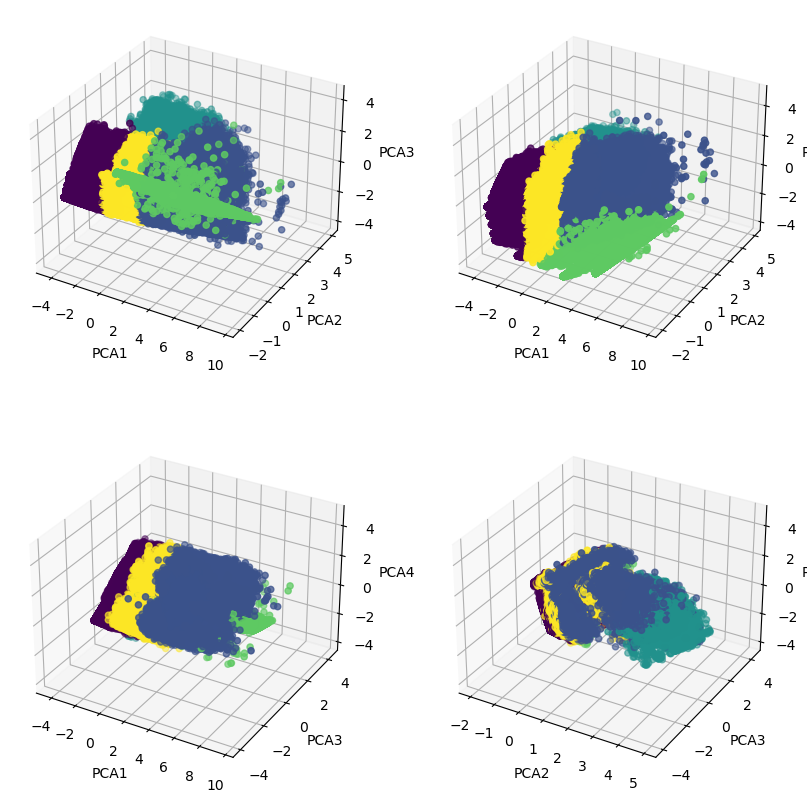

In [38]:
# plot the clusters on a 3D scatter plot
fig = plt.figure(figsize=(10, 10))

# create 4 subplots with different PCA combinations
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(pca_df['PCA1'], pca_df['PCA2'], pca_df['PCA3'], c=pca_df['cluster'])
ax1.set_xlabel('PCA1')
ax1.set_ylabel('PCA2')
ax1.set_zlabel('PCA3')

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(pca_df['PCA1'], pca_df['PCA2'], pca_df['PCA4'], c=pca_df['cluster'])
ax2.set_xlabel('PCA1')
ax2.set_ylabel('PCA2')
ax2.set_zlabel('PCA4')

ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(pca_df['PCA1'], pca_df['PCA3'], pca_df['PCA4'], c=pca_df['cluster'])
ax3.set_xlabel('PCA1')
ax3.set_ylabel('PCA3')
ax3.set_zlabel('PCA4')

ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(pca_df['PCA2'], pca_df['PCA3'], pca_df['PCA4'], c=pca_df['cluster'])
ax4.set_xlabel('PCA2')
ax4.set_ylabel('PCA3')
ax4.set_zlabel('PCA4')


plt.show()

In [40]:
# group by year, agency, and cluster

all_survey_predictions.shape
# one hot encode the cluster column
one_hot_clusters = pd.get_dummies(all_survey_predictions, columns=['cluster'])

#drop feature columns
one_hot_clusters.drop(columns=feature_columns, inplace=True)
#drop predict_year
#one_hot_clusters.drop(columns='predict_year', inplace=True)

# group by year and agency, sum the values of each cluster column, remove all other columns
grouped_clusters = one_hot_clusters.groupby(['year', 'agency']).sum()

grouped_clusters.head(100)


cluster_0  cluster_1  cluster_2  cluster_3  cluster_4
year agency                                                       
2010 AF           2778       1911          0        323       5548
     AR           5179       3546          0        593      10095
     NV           3121       2142          0        402       6713
2011 AF           2232       1652          0        405       4486
     AR           4786       3382          0        665       9994
     NV           3348       2319          0        488       7182
2012 AF          14205      13490          0       3073      31139
     AR          16906      17945          0       4001      39096
     NV          14950      13698          0       2971      35985
2013 AF           2405       3015          0        491       6218
     AR           4025       6114          0        987      11004
     NV           3859       4490          0        768      10401
2014 AF           4071       4464          0        854       9779
     AR           4008       6222          0       1049      11135
     NV           3894       4682          0        712      10173
2015 AF           4501       4143          0        743       9389
     AR           4422       5389          0        755      10437
     NV           3861       4241          0        581       9208
2016 AF           4855       3398          0        774       6559
     AR           4924       4267          0        560       7335
     NV           3512       2753          0        437       5659
2017 AF           5480       3591          0        812       7016
     AR           7011       4642          0        677       9520
     NV           5190       3152          0        571       7109
2018 AF          10611       7247          0       1519      13974
     AR          23039      14557          0       1918      30491
     NV          14900       9531          0       1759      21692
2019 AF          12170       6857          0       2071      10250
     AR          35452      17169          0       2847      30171
     NV          19377      10139          0       3196      18606
2020 AF          15714       6643          0        307      12812
     AR          36149      15407          1        406      30192
     NV          22732       8802          0        356      20263
2021 AF           6868       2464          0        444       4072
     AR          19035       5613          0        704      10420
     NV          10457       3524          0        593       6527
2022 AF             57       4052      25488       1319        275
     AR             73       7941      50010       1823        431
     NV             75       5322      32621       1509        363

In [58]:
# check rounded stats for the stats on DEIA
rounded_stats.columns

# Select 'DEIA' columns
deia_stats = rounded_stats.xs('DEIA', level=0, axis=1)

deia_stats.reset_index(inplace=True)
deia_stats = deia_stats[deia_stats['year'] == 2022]
deia_stats.head()

,year,agency,count,mean,std,min,25%,50%,75%,max
48,2022,AF,29523.0,3.89,0.87,1.0,3.43,4.0,4.60,5.0
49,2022,AR,57963.0,3.87,0.86,1.0,3.43,4.0,4.55,5.0
50,2022,DD,30736.0,3.96,0.84,1.0,3.55,4.0,4.64,5.0
51,2022,NV,37954.0,3.86,0.84,1.0,3.43,4.0,4.50,5.0


In [ ]:
# create a merge year column which is one more than the year column
all_surveys['predict_year'] = all_surveys['year'] + 1
# join the all_surveys and all_end_strength dataframes on agency and year
all_surveys_strengths = all_surveys.merge(all_end_strength, how='left', left_on=['agency', 'predict_year'],
                                            right_on=['agency', 'year'])


In [ ]:
# drop the year_y column
all_surveys_strengths.drop(columns='year_y', inplace=True)
# rename the year_x column to year
all_surveys_strengths.rename(columns={'year_x': 'year'}, inplace=True)
# drop the predict_year column
all_surveys_strengths.drop(columns='predict_year', inplace=True)

#dummies on agency
agency_dummies = pd.get_dummies(all_surveys_strengths['agency'])

#drop agency column
all_surveys_strengths.drop(columns='agency', inplace=True)

#concatenate agency_dummies to all_surveys_strengths
all_surveys_strengths = pd.concat([all_surveys_strengths, agency_dummies], axis=1)

#fill all NaN values with 0
all_surveys_strengths.fillna(0, inplace=True)

all_surveys_strengths.shape

In [ ]:
all_surveys_strengths.head()

In [ ]:
nn_df = all_surveys_strengths.copy()
# remove all DD rows from the dataframe
nn_df = nn_df[nn_df['DD'] == 1]
# drop the DD column
nn_df.drop(columns='DD', inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))

# columns to scale
scale_columns = ['my_work_experience', 'my_work_unit', 'my_organization', 'my_supervisor', 'leadership',
                'my_satisfaction', 'employee_experience', 'circumstantial', 'DEIA', 'negativity_index', 'O10', 'O9', 'O8', 'O7', 'O6', 'O5', 'O4', 
                    'O3', 'O2', 'O1', 'W5', 'W4', 'W3', 'W2', 'W1', 'E9', 'E8', 'E7', 
                    'E6', 'E5', 'E4', 'E3', 'E2', 'E1']
# scale the data
nn_df[scale_columns] = scaler.fit_transform(nn_df[scale_columns])

X = nn_df.drop(columns=['O3'], axis=1).values
y = nn_df['O3'].values

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Reshaping data for LSTM input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Building a Stacked LSTM model
model_stacked = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model_stacked.compile(optimizer='adam', loss='mean_squared_error')

# Fit model
model_stacked.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

In [ ]:
# Make predictions on the test data
y_pred_stacked = model_stacked.predict(X_test)

# Reshape y_pred to ensure it has the same shape as y_test
y_pred_stacked = y_pred_stacked.reshape(y_pred_stacked.shape[0])

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_stacked)
print(f"Mean Squared Error: {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate R-squared (R2) - Coefficient of Determination
r2 = r2_score(y_test, y_pred_stacked)
print(f"R-squared: {r2}")

In [ ]:
def attention_layer(inputs, time_steps):
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, time_steps))(a)
    a = Dense(time_steps, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# Input layer
inputs = Input(shape=(1, X_train.shape[2]))

# LSTM layers with attention
lstm_out = LSTM(50, return_sequences=True)(inputs)
attention_mul = attention_layer(lstm_out, 1)
attention_mul = LSTM(50)(attention_mul)

# Final part of the network
output = Dense(1, activation='linear')(attention_mul)

model_attention = Model(inputs=[inputs], outputs=output)

model_attention.compile(optimizer='adam', loss='mean_squared_error')

# Fit model
model_attention.fit([X_train], y_train, epochs=100, batch_size=64, validation_data=([X_test], y_test))

In [ ]:
# Make predictions on the test data
y_pred_attention = model_attention.predict([X_test])

# Reshape y_pred to ensure it has the same shape as y_test
y_pred_attention = y_pred_attention.reshape(y_pred_attention.shape[0])

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_attention)
print(f"Mean Squared Error: {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

# Calculate R-squared (R2) - Coefficient of Determination
r2 = r2_score(y_test, y_pred_attention)
print(f"R-squared: {r2}")
